# Using DQN to cross a bridge in World of Warcraft

## The bridge
The bridge can be found at coordinates X:1669.62, Y:-3731.47, Z:148.3 in the zone Howling Fjord. The bridge have no rails thus the agent can easily fall off. The goal is to cross the bridge without falling down with the help of DQN. A trained agent should be able to cross. The bridge is also slightly tilted from the north.

For this task, Keras will be used for modeling the network.

 <table width="100%" border="0">
      <tr>
      <td><img src="images/bridge.png"/></td>
      <td><img src="images/bridge2.png"/></td>
      </tr>
    </table>


In [1]:
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, EarlyStopping
from keras.initializers import RandomUniform

from collections import deque

import random
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from ctypes import cdll, POINTER, c_float, c_int
from random import randint
from time import sleep

from IPython.display import clear_output

Using TensorFlow backend.


## Measured constants
The first step was to measure the bridge as a polygon concealed within four points. These four points are initalized below and were measured from the World of Warcraft client. The inital start position x and y is between the eastern and western starting point.

The variables k and m are the linear equation between the end points on the other side of the bridge. This linear equation is useful to determine if the agent passed the end of the bridge or not.

The step size is equal to half the width of the bridge. This will determine how many units the agent will move in every step. The bridge is contained within a polygon that will use the raycasting algorithm to decide if the agent is in or outside the polygon aka the bridge.

The image visualize the polygon that surrounds the bridge in the simulation.

<img src="images/poly.png"/>

In [2]:
bridge_start_west = np.array([-3728.34, 1668.16])
bridge_start_east = np.array([-3734.89, 1668.64])

bridge_end_west = np.array([-3735.31, 1580.07])
bridge_end_east = np.array([-3741.63, 1580.53])

init_pos = np.sum([bridge_start_west, bridge_start_east], axis=0) / 2

k = (bridge_end_west[1] - bridge_end_east[1]) / (bridge_end_west[0] - bridge_end_east[0])
m = bridge_end_west[1] -(k * bridge_end_west[0])

step_size = np.abs((bridge_start_west[0] - bridge_start_east[0]) / 2)

current_angle = 0

polygon = Polygon([bridge_start_west, bridge_start_east, bridge_end_east, bridge_end_west])

## Determine goal

The goal line can be defined as:

\begin{align}
y = kx + m
\end{align}

If the agents current y position is less than the goals y, the agent crossed the bridge. The reason why the agent y have to be lesser is beacuse it move in a north to south direction.

In [3]:
def is_goal(x, y):
      
    goal_y = (k*x) + m
    
    return y < goal_y    

## Is within bridge
This is calculated with the Shapley library that implement the raycasting algorithm.

In [4]:
def is_within_bridge(x, y):
    
    point = Point(x, y)
    
    return polygon.contains(point) 

## Calculate distance from the right edge

To determine the distance to the right edge, the linear equation is calculated for the right sided line. This will be used to later calculate the perpendicular line. The x position in realtion to the edge can then be solved by finding what x is intersection both lines. The euclidean distance can then be used once we have the x and y on the right edge line compared to the agents current position.

The first two methods are only used to plot how far the agent reach after each episode.

In [5]:
def get_start_edge():
    
    k_s = (bridge_start_west[1] - bridge_start_east[1]) / (bridge_start_west[0] - bridge_start_east[0])
    m_s = bridge_start_west[1] -(k_s * bridge_start_west[0])
    
    return k_s, m_s
    
k_s, m_s = get_start_edge()

In [6]:
def get_start_edge_dist(x, y):
    
    k_p = -1 / k_s
    m_p = y - (k_p * x);

    x_new = (m_p - m_s) / (k_s - k_p);
    y_new = (k_s*x_new) + m_s;

    a = (x_new - x);
    b = (y_new - y);

    d = np.sqrt(a**2 + b**2);
    
    return d

In [7]:
def get_right_edge():
    
    k_r = (bridge_start_west[1] - bridge_end_west[1]) / (bridge_start_west[0] - bridge_end_west[0])
    m_r = bridge_end_west[1] -(k_r * bridge_end_west[0])
    
    return k_r, m_r
    
k_r, m_r = get_right_edge()

In [8]:
def get_edge_dist(x, y):
    
    k_p = -1 / k_r
    m_p = y - (k_p * x);

    x_new = (m_p - m_r) / (k_r - k_p);
    y_new = (k_r*x_new) + m_r;

    a = (x_new - x);
    b = (y_new - y);

    d = np.sqrt(a**2 + b**2);
    
    return d

## Avaliable actions
The agent have four avaliable actions that follows:

<ol>
    <li>Adjust angle $+\frac{\pi}{8}$ radians</li>
    <li>Adjust angle $+\frac{\pi}{4}$ radians</li>
    <li>Adjust angle $-\frac{\pi}{8}$ radians</li>
    <li>Adjust angle $-\frac{\pi}{4}$ radians</li>
</ol>


In [9]:
def get_new_angle(action):  
    
    v = np.pi / 8
    
    return{
        0 : current_angle + v,
        1 : current_angle + v*2,
        2 : current_angle - v,
        3 : current_angle - v*2,
    }[action]

## New position from predicted angle

Once the new angle is predicted, the new position can be determined from the current position. The figure below visualizes how the triangle can look before a step where the current angle is equal to $\alpha$. Since $sin(\alpha) = \frac{a}{c}$ and $cos(\alpha) = \frac{b}{c}$, $a$ and $b$ can be calculated from this. The new position $x'$ and $y'$ ten evaluates to: $x' = x + a$, $y' = y + b$.

<img src="images/tri.png"/>

In [10]:
def do_action(action, x, y):
        
    v = get_new_angle(action)
    current_angle = v
    
    a = step_size * np.sin(v);
    b = step_size * np.cos(v);

    x_new = x - a;
    y_new = y - b;
    
    return x_new, y_new

## Rewards
These are the rewards that will determine how the agent perform. 

In [11]:
terminate_reward = 100
step_reward = -1
stuck_reward = -100

state_size = 2
action_size = 4

## Step
The state contain two variables, the curent angle and the distance to the right edge in realtion to the agent. 

In [12]:
def step(action, p_x, p_y):
    
    tmp_player_x = p_x
    tmp_player_y = p_y
    
    new_pos = do_action(action, p_x, p_y)
    
    p_x = new_pos[0]
    p_y = new_pos[1]
    
    reward = 0
    done = False
    
    if is_goal(p_x, p_y):
        done = True
        reward = terminate_reward
    
    elif is_within_bridge(p_x, p_y):
        reward = step_reward
            
    else:
        p_x = tmp_player_x
        p_y = tmp_player_y
        reward = stuck_reward;
        done = True
            
    state = np.reshape([current_angle, get_edge_dist(p_x, p_y)], [1, state_size])
        
    return state, reward, done, p_x, p_y
    

In [13]:
def reset():
    
    p_x = init_pos[0]
    p_y = init_pos[1]
    
    current_angle = 0
    
    state = np.reshape([current_angle, get_edge_dist(p_x, p_y)], [1, state_size])
    
    return state, p_x, p_y
    

## The DQN

The agent class contain the logic for the DQN. The netowrk consist of two hidden layers with 40 neurons each. The neural net is visualized below.

<img src="images/net.png"/>

In [14]:
model_path = "my_model.h5"

class Agent:
    def __init__(self, state_size, action_size, discount, eps, eps_decay, eps_min, l_rate, decay_linear):
        self.path = model_path
        self.state_size = state_size       
        self.action_size = action_size
        self.mem = deque(maxlen=2000)
        self.discount = discount
        self.eps = eps
        self.eps_decay = eps_decay
        self.decay_linear = decay_linear
        self.eps_min = eps_min
        self.l_rate = l_rate
        self.model = self.init_model()

    def load_model(self):
        return load_model(self.path)
        
    def save_model(self):
        self.model.save(self.path)

    def init_model(self):
        model = Sequential()
        model.add(Dense(40, input_dim=self.state_size, activation='relu'))
        model.add(Dense(40, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.l_rate))

        return model

    def action(self, state):

        if np.random.rand() <= self.eps:
            return random.randrange(self.action_size)   
        
        actions = self.model.predict(state)
        
        return np.argmax(actions[0])
    
    def remember(self, state, action, reward, next_state, terminal):
        self.mem.append((state, action, reward, next_state, terminal))

    def replay(self, batch_size):
        
        if len(self.mem) < batch_size:
            batch = self.mem
        else:
            batch = random.sample(self.mem, batch_size)
        
        for state, action, reward, next_state, terminal in batch:
            target = reward

            if not terminal:
                target += self.discount * np.amax(self.model.predict(next_state)[0])
            
            target_f = self.model.predict(state)
            target_f[0][action] = target
        
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        self.decay()


    def decay(self):
        if self.eps > self.eps_min:
            if self.decay_linear:
                self.eps -= self.eps_decay
            else:
                self.eps *= self.eps_decay
            

In [34]:
agent = Agent(
            state_size = state_size, 
            action_size = action_size, 
            discount = 0.98, 
            eps = 1, 
            eps_decay = 0.001, 
            eps_min = 0.001, 
            l_rate = 0.001,
            decay_linear = True
            )

#Train agent
episodes = 2000
steps = 100

print_freq = 100
goalCounter = 0
goalAvg = -1
stepCounter = 0
epGoalCounter = 0
epGoalAvg = -1
epStepCounter = 0

total_ep = []
total_rewards = []
total_distance = []

for ep in range(1, episodes + 1):
    
    state, p_x, p_y = reset()

    player_x = p_x
    player_y = p_y
    
    total_reward = 0
    
    for st in range(1, steps):
        
        action = agent.action(state)

        next_state, reward, done, p_x, p_y = step(action, player_x, player_y)
        
        total_reward += reward
        
        player_x = p_x
        player_y = p_y
        
        agent.remember(state, action, reward, next_state, done)

        state = next_state

        if done:
            
            if reward > 1:
                goalCounter += 1
                epGoalCounter += 1            
                epStepCounter += st
                epGoalAvg = epStepCounter / epGoalCounter
            break
       
    agent.replay(32)
        
    if ep % print_freq == 0 or ep == 1:
        
        total_ep.append(ep)
        total_rewards.append(total_reward)
        total_distance.append(get_start_edge_dist(player_x, player_y))
        
        print("episode {} done, found goal {} times with and avg step of {}, total goals: {}".format(ep, epGoalCounter, epGoalAvg, goalCounter))
        epGoalCounter = 0
        epGoalAvg = -1
        epStepCounter = 0

agent.save_model()
print("summary: total goals found: {}, an avg of {} episodes reached the goal".format(goalCounter, goalCounter/episodes))

episode 1 done, found goal 0 times with and avg step of -1, total goals: 0
episode 100 done, found goal 0 times with and avg step of -1, total goals: 0
episode 200 done, found goal 0 times with and avg step of -1, total goals: 0
episode 300 done, found goal 2 times with and avg step of 32.0, total goals: 2
episode 400 done, found goal 1 times with and avg step of 31.0, total goals: 3
episode 500 done, found goal 7 times with and avg step of 31.857142857142858, total goals: 10
episode 600 done, found goal 10 times with and avg step of 31.8, total goals: 20
episode 700 done, found goal 17 times with and avg step of 32.05882352941177, total goals: 37
episode 800 done, found goal 28 times with and avg step of 31.535714285714285, total goals: 65
episode 900 done, found goal 51 times with and avg step of 30.666666666666668, total goals: 116
episode 1000 done, found goal 94 times with and avg step of 31.30851063829787, total goals: 210
episode 1100 done, found goal 100 times with and avg step

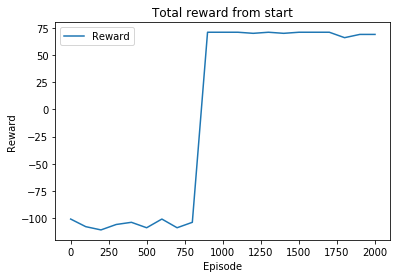

In [45]:
plt.plot(total_ep, total_rewards)
plt.title('Total reward from start')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(['Reward'], loc='upper left')
plt.show()

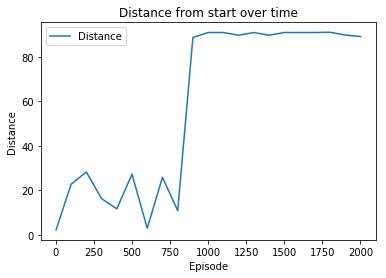

In [44]:
plt.plot(total_ep, total_distance)
plt.title('Distance from start over time')
plt.ylabel('Distance')
plt.xlabel('Episode')
plt.legend(['Distance'], loc='upper left')
plt.show()

## Testing the trained network in the client
The last step is to confirm that the trained network works in the World of Warcraft client. To do this Click to move was used  to walk towards a given x and y. This is an built in function for World of Warcraft. This can be accsed by manipulating memory variables with a language such as C++. The python class ctypes allow for calls to compiled C++ classes. The libenv.so were compiled with MinGW and the source code for this library can be found at: https://github.com/Jacobth/wow_rl_environment.

In [15]:
lib = cdll.LoadLibrary('libenv.so')

class Env(object):
    def __init__(self):
        self.obj = lib.Env()
    
    def reset(self, init_x, init_y):
        lib.ResetTest.argtypes = [c_float, c_float]
        lib.ResetTest(self.obj, init_x, init_y)

    def step(self, new_x, new_y):
        lib.StepTest.argtypes = [c_float, c_float]
        lib.StepTest(self.obj, new_x, new_y)
        
    def get_pos(self):      
        lib.GetPos.restype = POINTER(c_float * 2)
        
        values = lib.GetPos(self.obj).contents
        x = values[0]
        y = values[1]
        
        return x, y

In [21]:
def test_model() :
    
    env = Env()

    model = load_model(model_path)
    
    state, p_x, p_y = reset()
    env.reset(c_float(p_x), c_float(p_y))
    
    pl_x = p_x
    pl_y = p_y
    
    total_reward = 0
    total_steps = 0
    
    while True:
    
        action = np.argmax(model.predict(state)[0])
        next_state, reward, done, p_x, p_y = step(action, pl_x, pl_y)
                
        env.step(c_float(p_x), c_float(p_y))
        
        state = next_state
        
        pl_x = p_x
        pl_y = p_y
        
        total_reward += reward
        total_steps += 1
        
        if done:
            print("completed with reward: {} and {} steps.".format(total_reward, total_steps))
            break;
            
test_model()

completed with reward: 69 and 32 steps.


This method can be used to test if the right distance behave correctly in the client.

In [1]:
def test_dist() :
    
    env = Env()
    
    while True:
        
        x, y = env.get_pos()
        
        print(get_edge_dist(x, y))
        sleep(0.5)
        clear_output()
        
#test_dist() 